# Simple Plots

This notebook is intended to provide some example/sample infrastructure for creating standard, simple plots that scientists might want to use to visualize CMIP6 data. We've included a few examples:

1. Timeseries from `historical` run ensemble members

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import seaborn as sns

import cartopy.crs as ccrs

## Initialization


### Dask / Distributed

Here we instantiate our dask-kubernetes cluster and attach to a client. We're assuming that this is available... if not, skip these two cells!

In [3]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=4)
cluster.adapt(minimum=1, maximum=40)
cluster

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.168.9:44853 Dashboard: /user/0000-0002-8270-4831/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load Data

Here we use `intake_esm` to read in some of the model data. We're providing hooks for both the data catalog on Glade and GCP.

In [73]:
import intake

if util.is_ncar_host():
    print("On NCAR")
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    print("On GCP")
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

Choose a specific model and field to use later on in our plots.

In [73]:
variable_id = 'tas'
institution_id = 'MIROC'
source_id = 'MIROC6'

cat = col.search(
    experiment_id=['piControl', 'historical', 'ssp585'],
    variable_id=variable_id,
    source_id=[source_id, ]
)
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
9520,CMIP,MIROC,MIROC6,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r10i1p...,NaN
9576,CMIP,MIROC,MIROC6,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1...,NaN
9624,CMIP,MIROC,MIROC6,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r2i1p1...,NaN
9672,CMIP,MIROC,MIROC6,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r3i1p1...,NaN
9720,CMIP,MIROC,MIROC6,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r4i1p1...,NaN
9768,CMIP,MIROC,MIROC6,historical,r5i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r5i1p1...,NaN
9816,CMIP,MIROC,MIROC6,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r6i1p1...,NaN
9864,CMIP,MIROC,MIROC6,historical,r7i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r7i1p1...,NaN
9912,CMIP,MIROC,MIROC6,historical,r8i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r8i1p1...,NaN
9960,CMIP,MIROC,MIROC6,historical,r9i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/MIROC/MIROC6/historical/r9i1p1...,NaN


In [74]:
dset_dict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated': True, 
                 'decode_times': True},
    cdf_kwargs={},
)
# list(dset_dict.keys())

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)


In [75]:
print("... we loaded!")

... we loaded!


Go ahead and load in the data - we're going to seed our later analyses by pulling out re *piControl*, *historical*, and *ssp585* simulations. We do some very light pre-processing, too:

1. "Squeeze" any unit coords/dimensions.
2. Select a subset of the `Dataset` we loaded which only includes the variable of interest. This also helps clip out unneeded data.
3. Enforce decoding based on CF-Conventions.

In [76]:
pi = f'CMIP.{institution_id}.{source_id}.piControl.Amon.gn'
hist =  f'CMIP.{institution_id}.{source_id}.historical.Amon.gn'
fut = f'ScenarioMIP.{institution_id}.{source_id}.ssp585.Amon.gn'

def _pre_process(ds, variable_id=variable_id):
    """ Some standard QoL to pre-process the data we pulled
    in from out catalog.
    
    """
    ds = ds.squeeze()
    ds = ds[[variable_id, ]]
    ds = xr.decode_cf(ds)
    return ds

pi_ds = dset_dict[pi].pipe(_pre_process)
hist_ds = dset_dict[hist].pipe(_pre_process)
fut_ds = dset_dict[fut].pipe(_pre_process)

## Historical Global Avg Timeseries 

Our first plot involves taking global average timeseries of our historical data, and then plotting all the ensemble members for the model we chose on the same figure. 

We've supplied a function `area_grid()` which consumes 1D vectors of longitudes and latitudes, and creates a 2D mesh of grid cell areas. We can use this with another supplied function, `global_avg()`, which really just does a weighted average:

$$T_\mathrm{global}(t) = \frac{\mathrm{Area}(\phi, \lambda, t) \cdot T(\phi, \lambda, t)}{\sum\limits_{(\phi,\lambda)}\mathrm{Area}(\phi, \lambda, t)}$$

In [77]:
from tools import global_avg, area_grid

x = pi_ds.isel(time=0)
area = area_grid(x['lon'].data, x['lat'].data, asarray=False)

# We eagerly did the area grid calculation in memory, so let's
# turn it into a dask array now (inside a DataArray)
area = area.chunk()

Apply our `global_avg()` function to the datasets we previously pulled out.

In [78]:
pi_ds_gavg = global_avg(pi_ds, weights=area)
hist_ds_gavg = global_avg(hist_ds, weights=area)
fut_ds_gavg = global_avg(fut_ds, weights=area)

Now we need to compute yearly anomalies 

In [111]:
def yearly_dfs(ds, anom=False, time_dim='time'):
    yearly = ds.resample(**{time_dim: 'AS'}).mean()

    if anom:
        yearly = yearly - yearly.mean('time')
    
    years = yearly[time_dim].dt.year
    yearly['year'] = ((time_dim), years)
    
    return yearly.to_dataframe().reset_index()
    
print("PI... ", end="")
pi_df_gavg = pi_ds_gavg.pipe(yearly_dfs, anom=False)
print("done")
print("HIST... ", end="")
hist_df_gavg = hist_ds_gavg.pipe(yearly_dfs, anom=False)
print("done")
print("FUT... ", end="")
fut_df_gavg = fut_ds_gavg.pipe(yearly_dfs, anom=False)
print("done")

PI... done
HIST... done
FUT... done


Plot historical...

In [107]:
def make_multipanel_plot(nrows=1, ncols=1, size=4, aspect=3):
    """ Construct a multi-panel plot where each panel
    has an identical size. Note that passing nrows==ncols==1
    is equivalent to making a single, specially-sized 
    axis. """
    width = size*aspect*ncols
    height = size*nrows
    figsize = (width, height)
    
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    return fig, axs


def member_mean_plot(data, x, y,
                     member_kwargs={}, mean_kwargs={}):
    """ Create a timeseries plot showing the ensemble mean
    super-imposed over individual traces of each ensemble member.
    
    Parameters
    ----------
    data : pd.DataFrame
        A DataFrame with 'x' and 'y' as columns, as well as a
        column 'member_id' which corresponds to each member's
        unique identifier
    x, y : str
        Columns to plot on the ordinate and abcissa
    {member, mean}_kwargs : dict
        Additional kwargs to pass to each of the two plots.
        
    Returns
    -------
    Figure and axes with the plots.
    
    """
    fig, ax = make_multipanel_plot(size=4., aspect=2.)
    
    sns.lineplot(
        x=x, y=y, data=data, 
        units="member_id", estimator=None, lw=.6,
        ax=ax
    )
    sns.lineplot(
        x=x, y=y, data=data, 
        estimator='mean', ci='sd', lw=1.2, color='k',
        ax=ax
    )

    sns.despine(ax=ax)
    
    return fig, ax

Text(0.0, 1.0, 'MIROC - MIROC6')

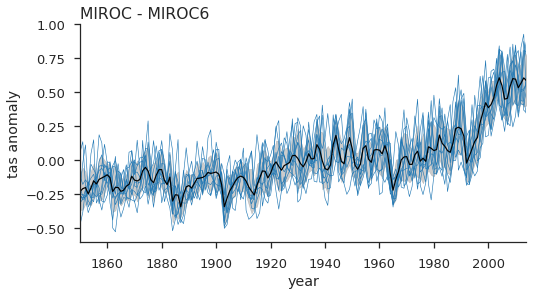

In [118]:
data = hist_df_gavg.copy()
hist_mean = hist_df_gavg[variable_id].mean()
data[f"{variable_id}_anom"] = data[variable_id] - hist_mean

fig, ax = member_mean_plot(data, 'year', f"{variable_id}_anom")

ax.set_xlim(data.year.min(), data.year.max())
ax.set_ylabel(f"{variable_id} anomaly")
ax.set_title(f'{institution_id} - {source_id}', loc='left')

Text(0.0, 1.0, 'MIROC - MIROC6')

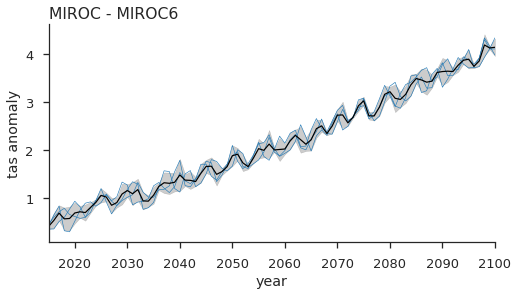

In [120]:
data = fut_df_gavg.copy()
data[f"{variable_id}_anom"] = data[variable_id] - hist_mean

fig, ax = member_mean_plot(data, 'year', f"{variable_id}_anom")

ax.set_xlim(data.year.min(), data.year.max())
ax.set_ylabel(f"{variable_id} anomaly")
ax.set_title(f'{institution_id} - {source_id}', loc='left')

---

We're going to start by computing yearly means for all of our `historical` and `ssp585` data.

<xarray.DataArray 'month' (time: 1980)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00

In [213]:
fut_ds.time.dt.year.count()

<xarray.DataArray 'year' ()>
array(1032)

In [ ]:

def _monthly_anom(ds):
    grouped = ds.groupby('time.month')
    return grouped - grouped.mean('time')

def _baseline_anom(ds, time_dim='time', 
                   time_bnds=('1920', '1960')):
    time_slice = slice(*time_bnds)
    return ds.sel(**{time_dim: time_slice})

def _yearly_mean(ds):
    return ds.groupby('time.year').mean('time')

# Select one ensemble member
_model_hist_ds = hist_ds.isel(member_id=3)

# Compute monthly anomalies (deseasonalize) and then 
# yearly means of these anomalies at each grid cell
hist_anom_ds = (
    _model_hist_ds
    .pipe(_monthly_anom)
    .pipe(_yearly_mean)
    .persist()
)
progress(hist_anom_ds)

# Globally average our anomaly timeseries
hist_anom_gavg_ds = (
    hist_anom_ds
    .pipe(global_avg, weights=area)
)

hist_anom_gavg_ds = hist_anom_gavg_ds.persist()
hist_anom_gavg_ds[variable_id].plot()

Fit our 4th order polynomial to our global average anomalies.

In [160]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=4)

y = hist_anom_gavg_ds[variable_id].values
x = hist_anom_gavg_ds['year'].values

x= x[:, np.newaxis]
y= y[:, np.newaxis]

xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

In [190]:
base_ts_ds = hist_anom_gavg_ds.copy().compute()
base_ts_ds[f'smoothed_{variable_id}'] = (('year', ), ypred)
base_ts_df = base_ts_ds.to_dataframe().reset_index()

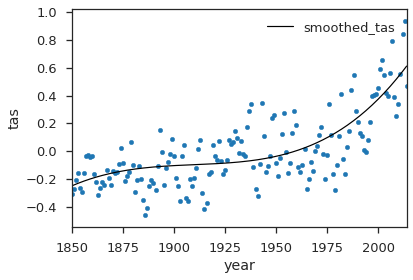

In [193]:
ax = base_ts_df.plot('year', variable_id, kind='scatter')
base_ts_df.plot('year', f'smoothed_{variable_id}', 
                color='k', lw=1.2, ax=ax)

Choose a local grid cell and regress against the smoothed global average

In [195]:
lon = 360 - 71
lat = 42

local_hist_ds = yearly_hist_ds.sel(lon=lon, lat=lat, 
                                   method='nearest')
local_anom_hist_ds = local_hist_ds - gavg_yearly_mean_ds

<xarray.Dataset>
Dimensions:    (time: 165)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1851-01-01 ... 2014-01-01
    member_id  <U9 'r4i1p1f1'
    lon        float64 289.7
    lat        float64 41.32
Data variables:
    tas        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [205]:
y = base_ts_ds[f'smoothed_{variable_id}'].values
x = local_anom_hist_ds[variable_id].values

x = x[:, np.newaxis]
y = y[:, np.newaxis]

xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, x).fit()
ypred = model.predict(x)

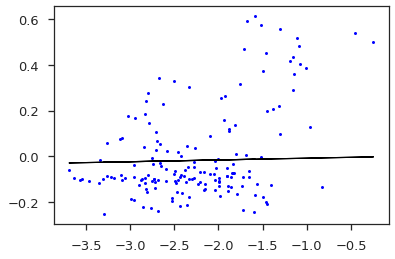

In [204]:
plt.plot(x, y, 'bo', ms=3)
plt.plot(x, ypred, 'k', lw=1.2)